# Week 2 실습 노트: 지도학습 · 비지도학습 정리

이 노트에서는 GDGoC EWHA AI week2 수업에서 다룬 내용을 바탕으로 다음 개념을 **설명 + 코드 실습**으로 정리합니다.

- 지도학습(Supervised Learning)
  - 회귀(Regression): 연속적인 값을 예측
    - Linear Regression
    - Random Forest Regression
  - 분류(Classification): 범주(label)를 예측
    - Logistic Regression
    - Decision Tree
- 비지도학습(Unsupervised Learning)
  - 차원축소(Dimensionality Reduction): PCA
  - 군집(Clustering): K-Means

각 섹션마다:

1. 개념 간단 정리
2. 데이터 전처리(결측치, 스케일링 등)
3. 모델 학습
4. 평가 및 시각화

까지 한 번에 연습할 수 있도록 구성했습니다.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.datasets import load_diabetes, load_breast_cancer, load_digits
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 한글 폰트 (리눅스/맥이면 적절히 수정)
plt.rcParams['axes.unicode_minus'] = False

RANDOM_STATE = 42


## 1. 지도학습 (Supervised Learning) - 회귀

- **지도학습**: 입력 데이터 `X`와 정답 레이블 `y`를 함께 주고, `X → y` 관계를 학습하는 방법입니다.
- **회귀(Regression)**: `y`가 **연속적인 값**일 때 사용하는 지도학습.
  - 예: BMI, 혈당, 인슐린 수치, 집값, 온도 등.

여기서는 `sklearn.datasets`의 **당뇨병 회귀 데이터셋(load_diabetes)** 을 사용해

1. 데이터 불러오기 & EDA
2. (예시) 0을 결측치로 보고 처리하기
3. 학습/테스트 데이터 분할 + 스케일링
4. **Linear Regression** 모델 학습 & 평가
5. **RandomForest Regression**과 비교

를 진행합니다.


In [2]:
# 1) 데이터 불러오기 (당뇨병 회귀 데이터셋)
diabetes = load_diabetes()
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = pd.Series(diabetes.target, name='disease_progression')

print("X shape:", X.shape)
print("y shape:", y.shape)

X.head()


X shape: (442, 10)
y shape: (442,)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


None

,count,mean,std,min,25%,50%,75%,max
age,442.0,-2.511817e-19,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,1.230790e-17,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-2.245564e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,-4.797570e-17,0.047619,-0.112399,-0.036656,-0.005670,0.035644,0.132044
s1,442.0,-1.381499e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,3.918434e-17,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,-5.777179e-18,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,-9.042540e-18,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,9.293722e-17,0.047619,-0.126097,-0.033246,-0.001947,0.032432,0.133597
s6,442.0,1.130318e-17,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44611 (\N{HANGUL SYLLABLE GIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

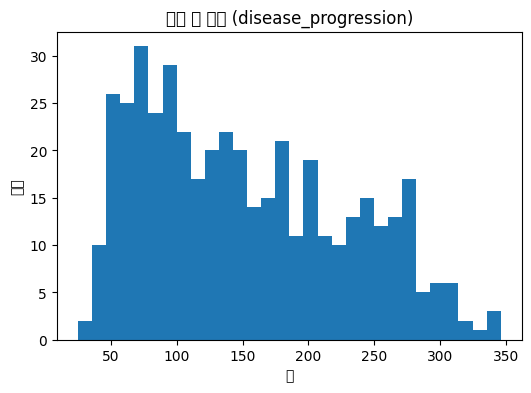

In [3]:
# 2) 기본 정보 확인 (EDA)
display(X.info())
display(X.describe().T)

plt.figure(figsize=(6, 4))
plt.hist(y, bins=30)
plt.title('타깃 값 분포 (disease_progression)')
plt.xlabel('값')
plt.ylabel('개수')
plt.show()


### (예시) 0을 결측치로 간주하여 처리하기

실제 의료 데이터(Pima Indians Diabetes 등)에서는

- BMI, 인슐린 수치처럼 **0이 나올 수 없는 변수**가
- 측정 실패 → **0으로 기록**되어 있는 경우가 많습니다.

이럴 때는 보통

1. 해당 변수에서 값이 0인 행을 `NaN` 으로 바꾸고
2. `NaN`을 제거하거나, 평균/중앙값으로 대체

하는 식으로 처리합니다.

`load_diabetes` 데이터에는 실제로 0이 거의 없기 때문에, 여기서는 **설명용으로 가짜 0과 결측치 처리 과정**을 보여줍니다.


In [4]:
# (설명용) bmi 값이 작은 일부 샘플을 0으로 만들어 본 뒤, 0을 결측치로 처리하는 예시

X_demo = X.copy()

# bmi가 -0.05 이하인 샘플을 '측정 실패'라고 가정하고 0으로 만든다
mask = X_demo['bmi'] < -0.05
X_demo.loc[mask, 'bmi'] = 0.0

print('0으로 바뀐 bmi 개수:', (X_demo['bmi'] == 0).sum())

# 0을 결측치로 간주
X_demo['bmi'] = X_demo['bmi'].replace(0.0, np.nan)

# 결측치 개수 확인
print('\n결측치 개수:')
print(X_demo.isna().sum())

# 간단하게: 결측치가 있는 행을 모두 드랍
X_clean = X_demo.dropna()
y_clean = y.loc[X_clean.index]

print('\n결측치 제거 후 데이터 shape:', X_clean.shape)


0으로 바뀐 bmi 개수: 62

결측치 개수:
age     0
sex     0
bmi    62
bp      0
s1      0
s2      0
s3      0
s4      0
s5      0
s6      0
dtype: int64

결측치 제거 후 데이터 shape: (380, 10)


### 학습/테스트 분할 & 스케일링

- `train_test_split`으로 학습용 / 테스트용 데이터를 나눕니다.
- **스케일링(StandardScaler)**:
  - 각 특성(feature)을 평균 0, 표준편차 1로 변환
  - 선형 회귀, 로지스틱 회귀, K-Means 등에서 자주 사용


In [5]:
# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=RANDOM_STATE
)

# 스케일링 (훈련 데이터에만 fit, 그 기준으로 train/test 변환)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((304, 10), (76, 10))

### 1-1. 선형 회귀 (Linear Regression)

- 가정: 타깃 `y`가 입력 특성들의 **선형 결합**으로 표현될 수 있다고 본다.
- 장점: 해석이 쉽고, 계산이 빠름.
- 단점: 관계가 비선형일 때는 한계가 있음.


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

Linear Regression - MSE: 3486.0333486722507
Linear Regression - R^2: 0.3765021725941732


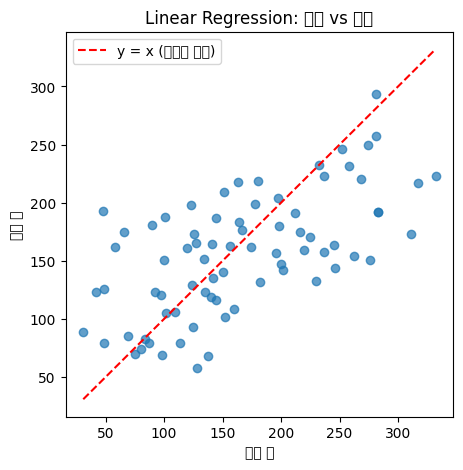

In [6]:
# Linear Regression 학습
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# 예측
y_pred_lr = lin_reg.predict(X_test_scaled)

# 평가 지표
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print('Linear Regression - MSE:', mse_lr)
print('Linear Regression - R^2:', r2_lr)

# 시각화: 실제값 vs 예측값
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred_lr, alpha=0.7)
max_val = max(y_test.max(), y_pred_lr.max())
min_val = min(y_test.min(), y_pred_lr.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x (이상적 예측)')
plt.xlabel('실제 값')
plt.ylabel('예측 값')
plt.title('Linear Regression: 실제 vs 예측')
plt.legend()
plt.show()


### 1-2. 랜덤 포레스트 회귀 (Random Forest Regression)

- 여러 개의 **결정 트리(Decision Tree)**를 학습시키고, 그 예측을 평균내는 앙상블 모델.
- 장점
  - 비선형 관계도 잘 잡는다.
  - 특성 간 복잡한 상호작용도 일부 반영.
- 단점
  - 해석이 어렵고, 트리 개수가 많을수록 느려질 수 있음.


In [7]:
# Random Forest Regressor 학습
rf_reg = RandomForestRegressor(
    n_estimators=200,
    random_state=RANDOM_STATE
)
rf_reg.fit(X_train, y_train)  # 트리는 스케일링 없이도 잘 동작하므로 원본 사용

# 예측
y_pred_rf = rf_reg.predict(X_test)

# 평가 지표
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print('Random Forest Regression - MSE:', mse_rf)
print('Random Forest Regression - R^2:', r2_rf)

# 비교 출력
print('\n=== 비교 ===')
print('Linear Regression  : MSE = {:.3f}, R^2 = {:.3f}'.format(mse_lr, r2_lr))
print('RandomForestRegress: MSE = {:.3f}, R^2 = {:.3f}'.format(mse_rf, r2_rf))


Random Forest Regression - MSE: 3810.721207565789
Random Forest Regression - R^2: 0.31842981517330216

=== 비교 ===
Linear Regression  : MSE = 3486.033, R^2 = 0.377
RandomForestRegress: MSE = 3810.721, R^2 = 0.318


## 2. 지도학습 - 분류 (Classification)

- **분류**: 타깃 `y`가 **카테고리/클래스(label)**일 때 사용하는 지도학습.
  - 예: 당뇨병 여부(0/1), 암 여부(양성/악성), 이메일 스팸/정상 등.

여기서는 유방암 진단 데이터셋(`load_breast_cancer`)으로

1. Logistic Regression (로지스틱 회귀)
2. Decision Tree (결정 트리 분류기)

를 비교합니다.

> 로지스틱 회귀(Logistic Regression)는 이름에 *회귀*가 들어가지만, 실제로는 **이진 분류 모델**입니다.


In [8]:
# 1) 데이터 불러오기 (Breast Cancer)
cancer = load_breast_cancer()
X_c = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y_c = pd.Series(cancer.target, name='target')

print('클래스 이름:', cancer.target_names)
print('타깃 분포:\n', y_c.value_counts())

X_c.head()


클래스 이름: ['malignant' 'benign']
타깃 분포:
 target
1    357
0    212
Name: count, dtype: int64


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [9]:
# 결측치 여부 확인
print(X_c.isna().sum().sum(), '개의 결측치가 있습니다. (0이면 없음)')

# train/test split
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_c, y_c, test_size=0.2, random_state=RANDOM_STATE, stratify=y_c
)

# 스케일링 (로지스틱 회귀에 특히 중요)
scaler_c = StandardScaler()
Xc_train_scaled = scaler_c.fit_transform(Xc_train)
Xc_test_scaled = scaler_c.transform(Xc_test)


0 개의 결측치가 있습니다. (0이면 없음)


### 2-1. Logistic Regression (이진 분류)

- 선형 결합 `w·x + b`를 **시그모이드(sigmoid)** 함수에 통과시켜
  - 0과 1 사이의 값을 **확률(probability)**로 해석.
- 기준(threshold, 보통 0.5)을 넘으면 1, 아니면 0으로 예측.


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47148 (\N{HANGUL SYLLABLE RYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


Logistic Regression 정확도: 0.9824561403508771


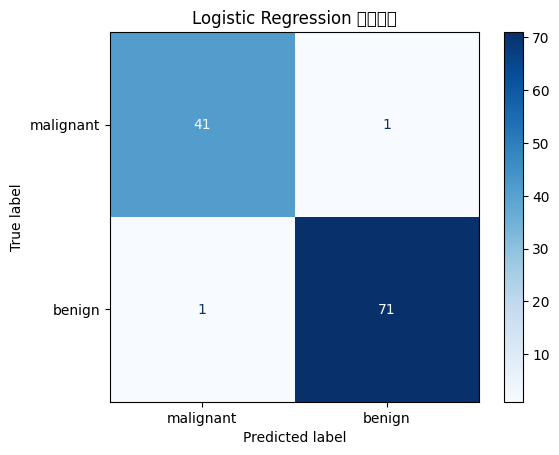

In [10]:
log_clf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
log_clf.fit(Xc_train_scaled, yc_train)

yc_pred_log = log_clf.predict(Xc_test_scaled)

acc_log = accuracy_score(yc_test, yc_pred_log)
print('Logistic Regression 정확도:', acc_log)

cm_log = confusion_matrix(yc_test, yc_pred_log)
disp = ConfusionMatrixDisplay(cm_log, display_labels=cancer.target_names)
disp.plot(cmap='Blues')
plt.title('Logistic Regression 혼동행렬')
plt.show()


### 2-2. Decision Tree Classifier (결정 트리)

- 데이터를 **질문(조건)**으로 계속 쪼개 나무 모양 구조를 만든 모델.
- 장점
  - 결과를 사람이 이해하기 쉽다.
  - 스케일링 필요 없음.
- 단점
  - 깊이를 제한하지 않으면 과적합(overfitting) 위험이 크다.

여기서는 `max_depth`를 조절하면서 트리의 복잡도를 제한합니다.


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47148 (\N{HANGUL SYLLABLE RYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


Decision Tree 정확도: 0.9385964912280702


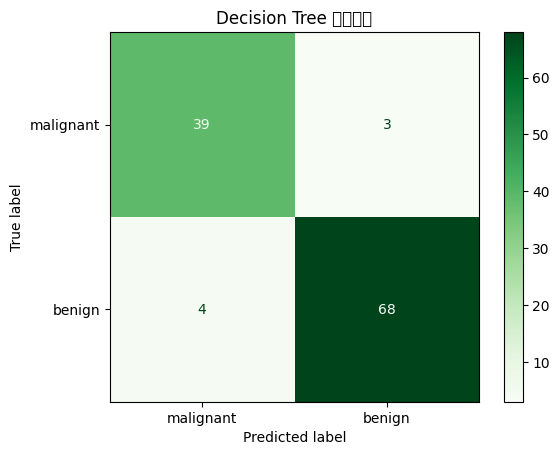

In [11]:
tree_clf = DecisionTreeClassifier(
    max_depth=4,      # 너무 깊어지지 않도록 제한
    random_state=RANDOM_STATE
)
tree_clf.fit(Xc_train, yc_train)

yc_pred_tree = tree_clf.predict(Xc_test)

acc_tree = accuracy_score(yc_test, yc_pred_tree)
print('Decision Tree 정확도:', acc_tree)

cm_tree = confusion_matrix(yc_test, yc_pred_tree)
disp = ConfusionMatrixDisplay(cm_tree, display_labels=cancer.target_names)
disp.plot(cmap='Greens')
plt.title('Decision Tree 혼동행렬')
plt.show()


In [12]:
print('=== 분류 모델 비교 ===')
print('Logistic Regression 정확도  :', acc_log)
print('Decision Tree 정확도       :', acc_tree)


=== 분류 모델 비교 ===
Logistic Regression 정확도  : 0.9824561403508771
Decision Tree 정확도       : 0.9385964912280702


## 3. 비지도학습 (Unsupervised Learning) - 차원축소 & 군집

- **비지도학습**: 정답 레이블(label)이 없이, 데이터 안의 숨겨진 구조/패턴을 스스로 찾는 방법.
- 대표적인 예
  - **차원축소(Dimensionality Reduction)**: 고차원 데이터를 정보 손실을 최소화하면서 저차원으로 줄이기 (예: 64차원 → 2차원)
  - **군집(Clustering)**: 레이블 없이 비슷한 데이터끼리 그룹(클러스터)으로 묶기

여기서는 손글씨 숫자 데이터셋(`load_digits`, 8x8=64차원)을 사용해

1. PCA로 64차원을 2차원으로 축소하여 시각화
2. K-Means로 군집화 수행

을 해 봅니다.


In [13]:
digits = load_digits()
X_d = digits.data       # (n_samples, 64)
y_d = digits.target     # 실제 라벨 (0~9), 비지도 학습에서는 사용하지 않아도 됨

print('X_d shape:', X_d.shape)

# 스케일링
scaler_d = StandardScaler()
X_d_scaled = scaler_d.fit_transform(X_d)

# PCA: 64차원 -> 2차원
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_d_pca = pca.fit_transform(X_d_scaled)

print('설명된 분산 비율:', pca.explained_variance_ratio_)


X_d shape: (1797, 64)
설명된 분산 비율: [0.12033916 0.09561054]


/tmp/ipython-input-922549074.py:8: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-922549074.py:8: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-922549074.py:8: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-922549074.py:8: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-922549074.py:8: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-922549074.py:8: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-922549074.py:8: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/l

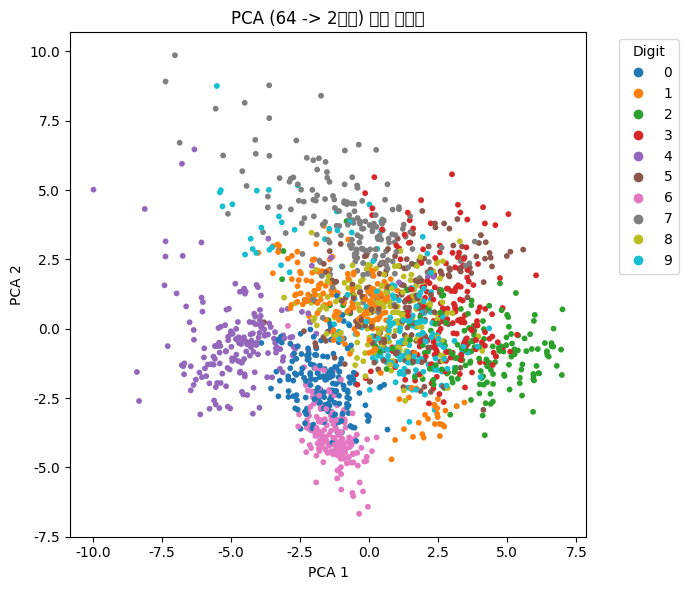

In [14]:
# PCA 결과 2차원 시각화 (색은 실제 숫자 라벨)
plt.figure(figsize=(7, 6))
scatter = plt.scatter(X_d_pca[:, 0], X_d_pca[:, 1], c=y_d, s=10, cmap='tab10')
plt.legend(*scatter.legend_elements(num=10), title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA (64 -> 2차원) 결과 시각화')
plt.tight_layout()
plt.show()


### K-Means 군집화

- K-Means: 데이터에서 **K개의 중심(centroid)**를 찾아, 각 점을 가장 가까운 중심에 배정하는 알고리즘.
- 여기서는 `K=10`으로 설정해 손글씨 숫자(0~9)에 해당하는 10개 군집을 시도해 봅니다.

> 비지도학습에서는 실제 정답 라벨을 사용하지 않지만, 여기서는 **시각화용으로만** 색깔을 비교해 봅니다.


/tmp/ipython-input-1240563963.py:10: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1240563963.py:10: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1240563963.py:10: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1240563963.py:10: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1240563963.py:10: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1240563963.py:10: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1240563963.py:10: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.tight_layo

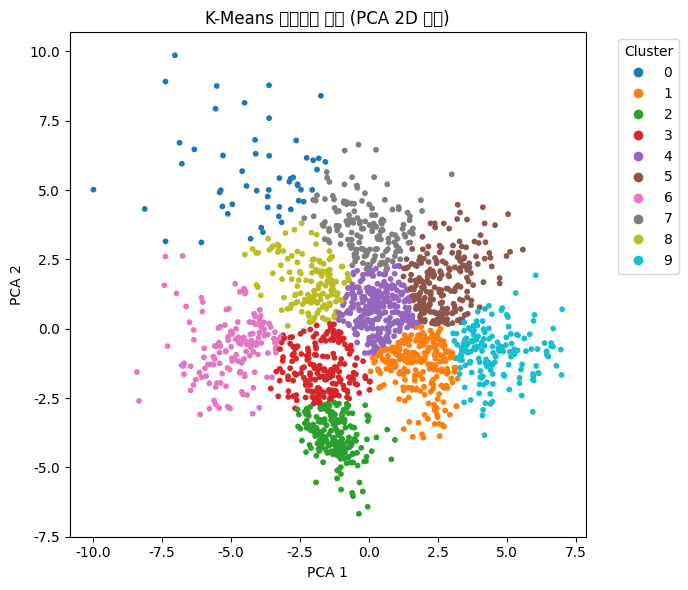

In [15]:
kmeans = KMeans(n_clusters=10, random_state=RANDOM_STATE)
cluster_labels = kmeans.fit_predict(X_d_pca)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(X_d_pca[:, 0], X_d_pca[:, 1], c=cluster_labels, s=10, cmap='tab10')
plt.legend(*scatter.legend_elements(num=10), title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('K-Means 클러스터 결과 (PCA 2D 공간)')
plt.tight_layout()
plt.show()


## 마무리 정리

이 노트에서 실습한 내용:

1. **지도학습 - 회귀**
   - 0을 결측치로 간주하여 처리하는 예시
   - Linear Regression vs Random Forest Regression
   - MSE, R²로 성능 비교 및 실제값-예측값 산점도 시각화

2. **지도학습 - 분류**
   - Logistic Regression (이진 분류, 확률 출력)
   - Decision Tree Classifier (나무 모양 모델, 해석 용이)
   - 정확도 & 혼동행렬로 성능 비교

3. **비지도학습**
   - PCA로 64차원 손글씨 데이터를 2차원으로 축소해 시각화
   - K-Means로 레이블 없이 군집화 수행

필요하면 각 셀의 파라미터(예: `max_depth`, `n_estimators`, `n_clusters`, `test_size` 등)를 바꿔 보면서
성능이 어떻게 변하는지 직접 실험해 보세요.
